In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az
from scipy.stats import entropy

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits
from matplotlib import cm


In [3]:
os.chdir('/home/walml/repos/agnfinder')

In [4]:

# save_dir = 'results/emulated_sampling/real'
# save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
# save_dir = 'results/emulated_sampling/30k_burnin'
# save_dir = 'results/emulated_sampling/latest_100000_1_optimised'
# save_dir = 'results/emulated_sampling/latest_100000_64_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_50000_16_optimised'

# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_16_optimised_no_metric'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_16_optimised_metric_by_chain'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_sigmoid'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_mvn_by_obs'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised_l10'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_128000_32_optimised_l10'
save_dir = 'results/emulated_sampling/latest_hmc_10000_40000_16_optimised'

# save_dir = 'results/vanilla_emcee'

assert os.path.isdir(save_dir)
all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')

# all_galaxy_locs = ['results/emulated_sampling/long_emcee/100k_samples_256_walkers_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/30k_burnin_70k_samples_256_walkers_ball_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/1k_burnin_50k_samples_256_walkers_ball_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/5k_burnin_100k_samples_256_walkers_ball_1x.h5']

# all_galaxy_locs = ['results/emulated_sampling/long_hmc/latest_hmc_3000_100000_64_optimised_x1.h5'] 
# all_galaxy_locs = ['results/emulated_sampling/long_hmc/latest_hmc_5000_300000_32_optimised_x1.h5'] 




assert all_galaxy_locs
print(len(all_galaxy_locs))

extra_thinning = 1

all_galaxy_locs = sorted(all_galaxy_locs)

1


In [5]:
# open one galaxy for params
with h5py.File(all_galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

marginal_bins = 50
dummy_array = np.zeros(42)  # anything
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)
                
galaxies = []
true_observations = len(all_galaxy_locs)
# for n, galaxy_loc in enumerate(galaxy_locs[0:]):  # thinned
for n, galaxy_loc in enumerate(all_galaxy_locs):  # thinned
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
#             if f['is_accepted'][...].mean() < 0.6:
#                 print(f['is_accepted'])
#             else:
                galaxy = {
#                     'free_param_names': f['free_param_names'],
                    'samples': np.squeeze(f['samples'][::extra_thinning]),
                    'name': galaxy_loc.split('_')[-3],
                    'chain': galaxy_loc.split('_')[-1].rstrip('.h5'),
                    'true_observations': np.squeeze(f['true_observations'][...]),
                    'true_params': np.squeeze(f['true_params'][...]),
                    'fixed_params': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...],
                }
                
                galaxies.append(galaxy)
                
    except OSError:
        pass
    
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [6]:
galaxy['samples'].shape

(40000, 16, 9)

In [7]:
galaxy = galaxies[0]

In [8]:
# galaxy_locs = [x for x in all_galaxy_locs if 'galaxy__' in x]

In [9]:
# galaxy_locs

In [10]:
# n_chains = 256
# # n_chains = 64
# # n_chains = 1
# by_chain = np.reshape(galaxy['samples'], (-1, n_chains, 8))

In [11]:
# by_chain = np.stack([np.squeeze(g['samples']) for g in galaxies], axis=1)
# by_chain.shape

In [12]:
# by_chain.shape
by_chain_raw = galaxy['samples']
param_dim = len(galaxy['true_params'])

In [13]:
# from agnfinder.tf_sampling.hmc import get_covariances

In [14]:
# cov, inv = get_covariances(by_chain)

In [15]:
# cov_np = np.cov(by_chain[:, 0].transpose())
# diag_mask = np.eye(8, 8).astype(bool)
# cov_masked = cov_np.copy()
# cov_masked[diag_mask] = np.nan

In [16]:
# np.matmul(x-x.mean(), (y-y.mean()).transpose())/len(x)

In [17]:
# x = by_chain[:, 0, 0]
# y = by_chain[:, 0, 4]
# plt.scatter(x, y)

In [18]:
# def manual_covariance(x, y):
#     x_mu = x.mean()
#     y_mu = y.mean()
#     return np.mean((x - x_mu)*(y-y_mu))

In [19]:
# manual_covariance(x, y) / (x.std() * y.std())

In [20]:
# d = np.stack([x, y])
# print(d.shape)
# np.cov(d)

In [21]:
# sns.heatmap(cov_np)

In [22]:
# sns.heatmap(cov_masked)

In [23]:
# np.sqrt(cov[0])

In [24]:
# sns.heatmap(cov[0])

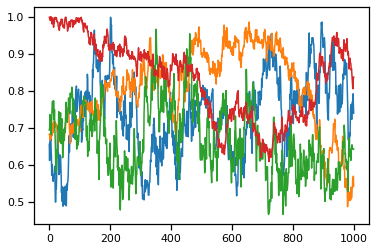

In [25]:
plt.plot(by_chain_raw[:1000, :4, 0])

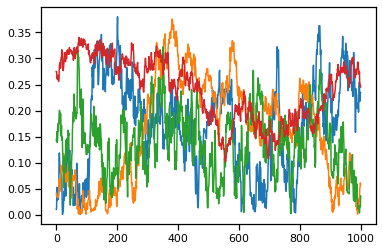

In [26]:
plt.plot(by_chain_raw[:1000, :4, 4])

In [27]:
def get_kl_vs_other_chains(chains, min_p=1e-5):
    n_chains = chains.shape[1]
    n_params = chains.shape[2]
    kl_divs = np.zeros([n_params, n_chains]) * np.nan
#     for param_n in range(n_params):
    for param_n in [0]:
        for chain_n in range(n_chains):
#             print(param_n, chain_n)
    #     for chain_n in [1]:
            mask = np.ones(n_chains).astype(bool)
            mask[chain_n] = False
            this_chain = chains[:, chain_n]
    #         other_chains = chains[:, mask]
            other_chains = chains
    #         print(this_chain.shape, other_chains.shape)
            bins = np.linspace(0., 1., 10)
            other_probs, _ = np.histogram(other_chains[:, :, param_n], density=True, bins=bins)
            this_probs, _ = np.histogram(this_chain[:, param_n], density=True, bins=bins)
            allowed_probs = (other_probs > min_p) & (this_probs > min_p)
    #         plt.plot(this_probs)
    #         plt.plot(other_probs)
    #         print(other_probs)
    #         print(this_probs)
            kl_divs[param_n, chain_n] = entropy(other_probs[allowed_probs], this_probs[allowed_probs])  # calculates KL of q (second arg) approximating p (first arg)
    return kl_divs

In [28]:
kl_divs = get_kl_vs_other_chains(by_chain_raw)
# print(kl_divs)

In [29]:
# fig, axes = plt.subplots(nrows=by_chain.shape[2], figsize=(8, 12))
# for n, ax in enumerate(axes):
#     ax.hist(kl_divs[n])
# fig.tight_layout()

In [30]:
worst_chain_n = np.argmax(kl_divs)
worst_chain_n

16

In [31]:
kl_divs = get_kl_vs_other_chains(by_chain_raw)
kl_divs = kl_divs[0]
print(kl_divs)
kl_is_successful = kl_divs < (np.median(kl_divs) + kl_divs.std() * 2)

typical_std = np.median(by_chain_raw.std(axis=0)[:, 0])
chain_stds = by_chain_raw.std(axis=0)[:, 0]
std_is_successful = chain_stds > typical_std * 0.1

print(std_is_successful)
chain_is_successful = kl_is_successful & std_is_successful
print(chain_is_successful)

[0.00101699 0.01927513 0.00059483 0.01386763 0.00265822 0.00107038
 0.00274125 0.01530197 0.03148713 0.01103348 0.00267924 0.00335201
 0.00255516 0.00247069 0.00185577 0.00285271]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[ True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True]


(array([11.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,  0.,  1.]),
 array([0.00059483, 0.00368406, 0.00677329, 0.00986252, 0.01295175,
        0.01604098, 0.01913021, 0.02221944, 0.02530867, 0.0283979 ,
        0.03148713]),
 <a list of 10 Patch objects>)

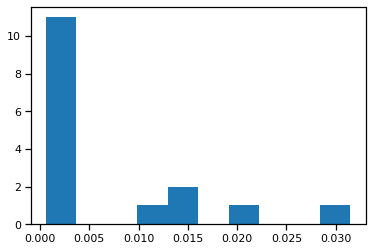

In [32]:
plt.hist(kl_divs, bins=10)

In [33]:
by_chain = by_chain_raw[:, chain_is_successful]

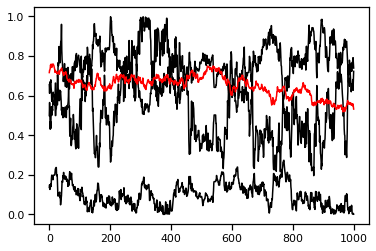

In [34]:
# plt.plot(by_chain_raw[:1000, chain_is_successful, 0].mean(axis=1), 'k--')
plt.plot(by_chain_raw[:1000, chain_is_successful, 0][:, 0], color='k')
plt.plot(by_chain_raw[:1000, chain_is_successful, 1][:, 0], color='k')
plt.plot(by_chain_raw[:1000, chain_is_successful, 2][:, 0], color='k')
plt.plot(by_chain_raw[:1000, ~chain_is_successful, 0][:, 0], color='r')

(array([   253.,   3325.,  18501.,  51020.,  86643., 104515., 111852.,
        105625.,  77392.,  40874.]),
 array([0.3153552 , 0.38381934, 0.45228347, 0.5207476 , 0.5892117 ,
        0.65767586, 0.72613996, 0.7946041 , 0.8630682 , 0.9315324 ,
        0.9999965 ], dtype=float32),
 <a list of 10 Patch objects>)

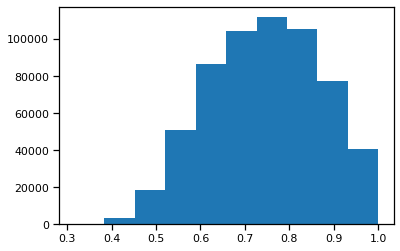

In [35]:
plt.hist(by_chain_raw[:, chain_is_successful, 0].flatten())

(array([ 412., 1481., 2950., 3623., 5685., 7602., 8376., 6139., 2833.,
         899.]),
 array([0.43050605, 0.48745468, 0.5444033 , 0.6013519 , 0.6583005 ,
        0.7152492 , 0.7721978 , 0.8291464 , 0.886095  , 0.94304365,
        0.99999225], dtype=float32),
 <a list of 10 Patch objects>)

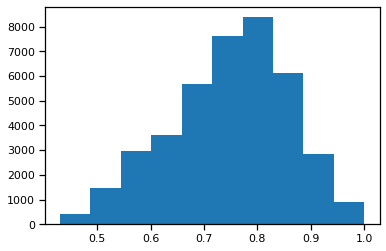

In [36]:
plt.hist(by_chain_raw[:, ~chain_is_successful, 0].flatten())

In [37]:
# from sklearn.metrics import adjusted_mutual_info_score

# adjusted_mutual_info_score(by_chain[:, 0, 0], by_chain[:, 4, 0])

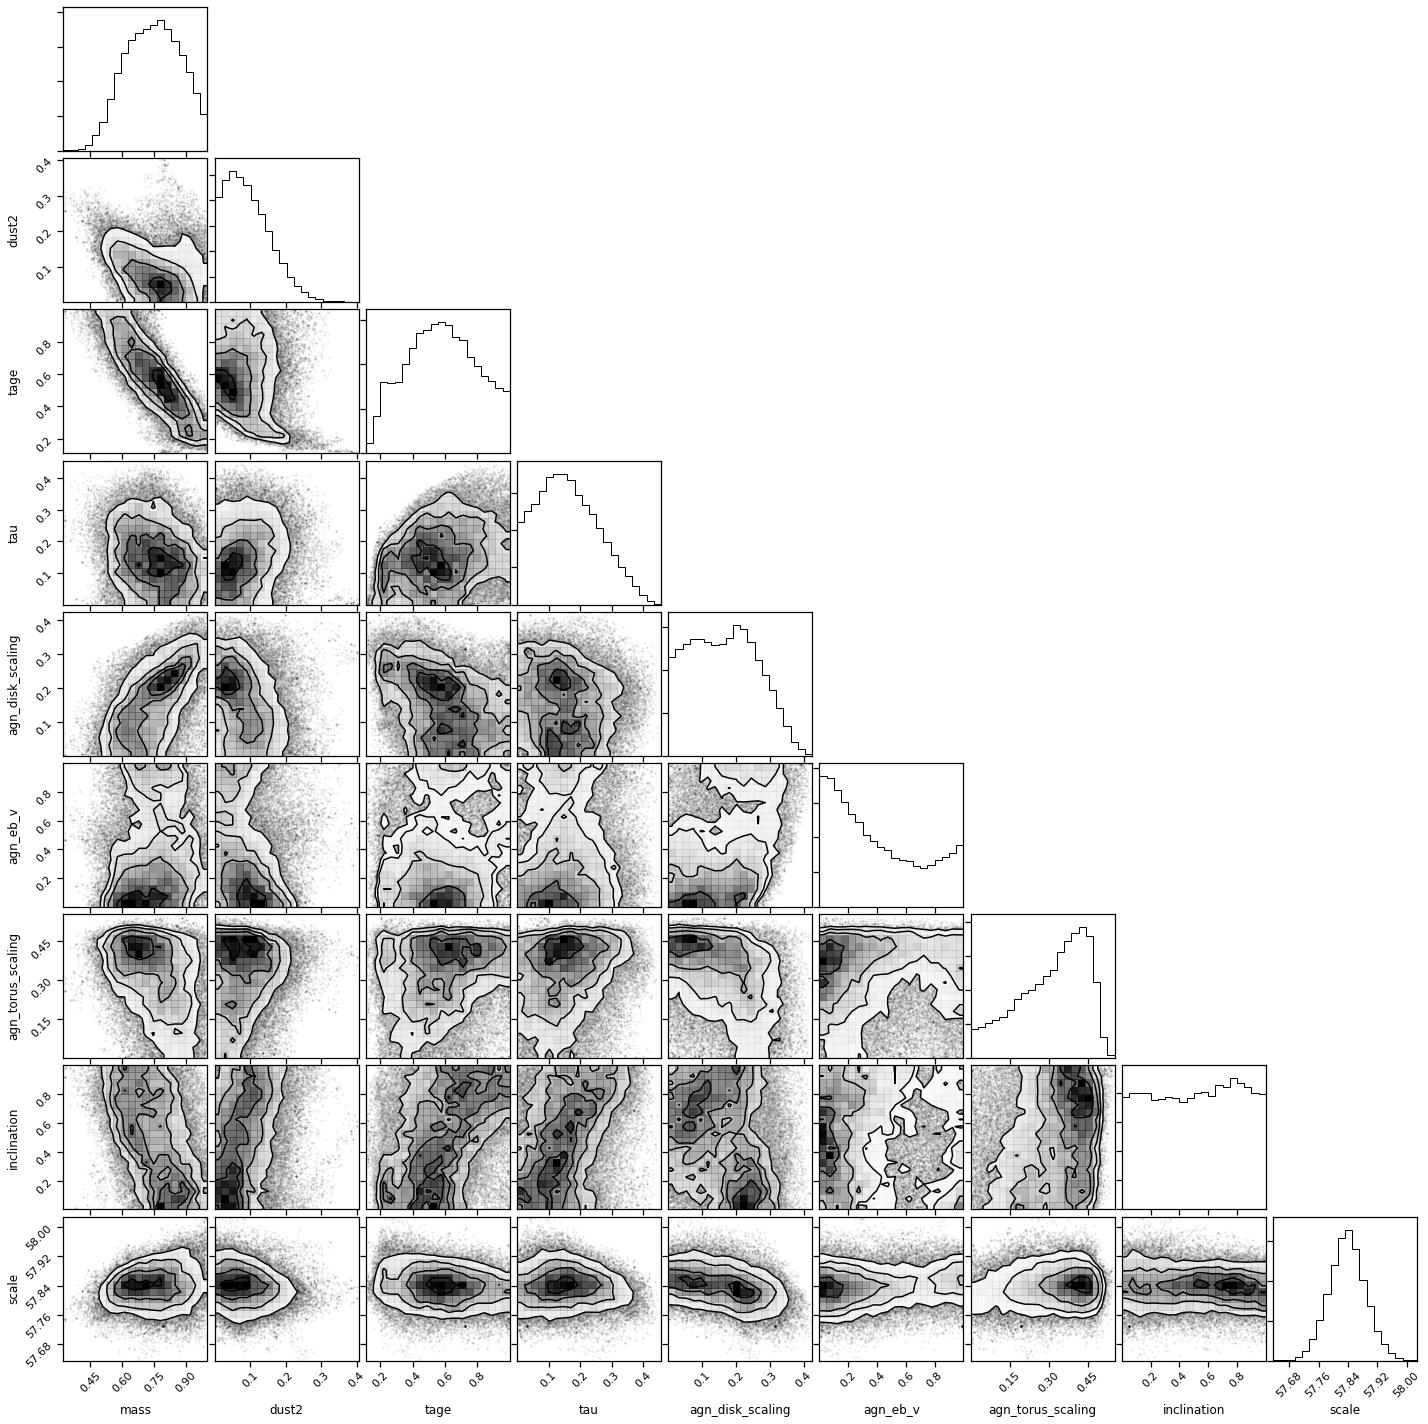

In [38]:
_ = corner.corner(by_chain_raw[:, 0, :], labels=params)

In [39]:
# _ = corner.corner(by_chain[:500].reshape(-1, 8), labels=params)  # early phase only

In [40]:
# _ = corner.corner(by_chain[-5000:].reshape(-1, 8), labels=params)  # late phase only

In [41]:
galaxy['true_params']

array([8.9256990e-01, 2.0321233e-02, 4.2358112e-01, 5.4227918e-02,
       2.1411249e-01, 6.3112611e-01, 2.2571769e-01, 7.3256600e-01,
       5.7860703e+01], dtype=float32)

In [47]:
true_params = galaxy['true_params']

In [145]:
def plot_corner(samples, true_params, labels):
    fig = corner.corner(samples, labels=labels)

    # Extract the axes
    axes = np.array(fig.axes).reshape((param_dim, param_dim))

    # Loop over the diagonal
    for i in range(param_dim):
        ax = axes[i, i]
        ax.axvline(true_params[i], color="g")

    true_params = galaxy['true_params']
    # Loop over the histograms
    for yi in range(param_dim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true_params[xi], color="g")
            ax.axhline(true_params[yi], color="g")

    fig

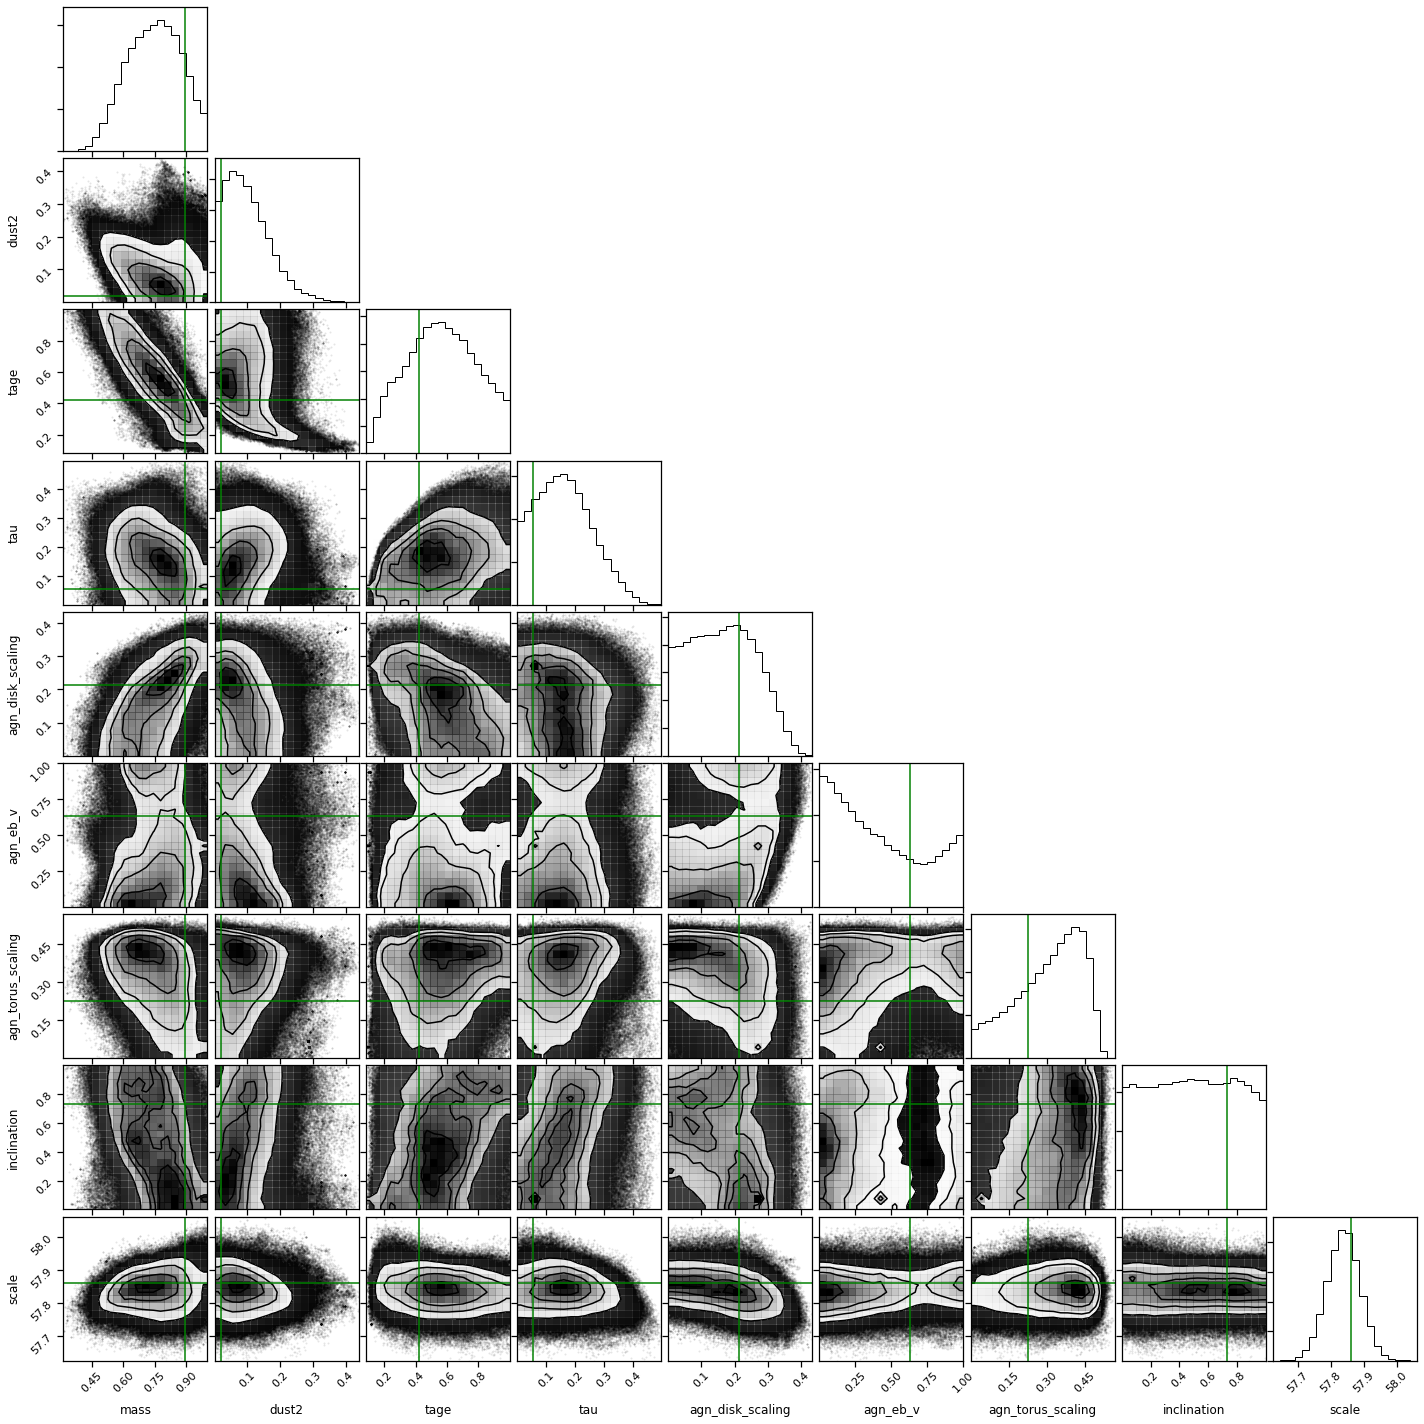

In [146]:
plot_corner(galaxy['samples'].reshape(-1, param_dim), true_params, params)

In [46]:
plot_corner(galaxy['samples'], true_params, params)

NameError: name 'true_params' is not defined

In [ ]:
plot_corner(by_chain_raw.reshape(-1, param_dim), true_params, params)

In [ ]:
# _ = corner.corner(by_chain.reshape(-1, param_dim), labels=params)

In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf

In [ ]:
samples = by_chain.reshape(-1, param_dim)
mu = np.mean(samples, axis=0)

cov = np.loadtxt('latest_cov.npy').astype(np.float32)
# cov = tfp.stats.covariance(samples)  # or just np cov?
chol = tf.linalg.cholesky(cov)
approx_dist = tfp.distributions.MultivariateNormalTriL(
    loc=mu, scale_tril=chol, validate_args=True, allow_nan_stats=False
)


bijector = tfp.bijectors.ScaleMatvecTriL(scale_tril=chol)

In [ ]:
bijector

In [ ]:
b = tfp.bijectors.ScaleMatvecTriL(scale_tril=[chol for _ in range(by_chain.shape[1])])


In [ ]:
b.inverse(by_chain).shape

In [ ]:
approximated_samples = approx_dist.sample(10000)
_ = corner.corner(approximated_samples, range=[[0, 1] for _ in range(8)])
# only mass/agn mass are strongly covariant, but the std of many params is very different (as expected, and already dealt with)

In [ ]:
uniform = tf.random.uniform([10000, 8])
_ = corner.corner(bijector.forward(uniform))

In [ ]:
sns.heatmap(cov)

In [ ]:
from agnfinder.tf_sampling.hmc import get_decorrelation_bijector

In [ ]:
observation_ids = [np.random.choice(['a', 'b']) for _ in range(by_chain.shape[1])]

In [ ]:
batch_bijector = get_decorrelation_bijector(by_chain, observation_ids)

In [ ]:
batch_bijector.forward_event_shape(tf.shape(uniform))

In [ ]:
batch_bijector.inverse(np.array([uniform for _ in range(29)]))

In [ ]:
for n in [100, 500, 5000]:
    b = get_decorrelation_bijector(by_chain[:n, 0])  # even w/ 1 chain, 1000 is about enough
    _ = corner.corner(b.inverse(samples))


In [ ]:
for n in [100, 1000, 5000]:
    b = get_decorrelation_bijector(samples[:n])  # merging across chains,  
    _ = corner.corner(b.inverse(samples))


In [ ]:
assert False

In [ ]:
_ = corner.corner(bijector.inverse(approximated_samples))

These have weird ranges, but are actually same scale - about 6

In [ ]:
_ = corner.corner(bijector.inverse(samples))

In [ ]:
# _ = corner.corner(by_chain_not_bad[::10].reshape(-1, 8), labels=params)

## Marginals

### Marginals, cut by n-samples

In [ ]:
def get_marginals(samples, marginal_bins=100, param_dim=9):
    dummy_array = np.zeros(42)  # anything
    _, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)

    marginals = np.zeros((param_dim, marginal_bins))
    for param_n in range(param_dim):
        marginals[param_n], _ = np.histogram(samples[:, :, param_n].flatten(), density=True, bins=param_bins)  # galaxy samples is still dim3, confusingly

    return marginals, param_bins

In [ ]:
params

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

# limits = [
#     [0., 1.],
# #     [.5, .6],
#     [.1, .5],
#     [0., .2],
#     [0., 0.2],
#     [0., 0.7],
#     [0., 1.],
#     [0., 0.6],
#     [0., 1.]
# ]
limits = [[0., 1.] for _ in range(len(params))]
limits[-1] = [None, None]  # scale parameter don't mess with

cuts = np.logspace(3, np.log10(len(by_chain)), num=6).astype(int)
# tau_est = np.array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453]) / 10.

max_chains = 16

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(cuts):
        marginals, bins = get_marginals(by_chain[:cut, :max_chains, :], marginal_bins=100, param_dim=len(params))
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=cut)
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()
    

### Marginals, cut by n-chains

Note that this is only relevant for HMC, as the performance by-chain for emcee is not defined - chains are dependent!

In [ ]:
true_params = galaxy['true_params']
true_params

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(5, by_chain.shape[1], num=5).astype(int)
max_samples = 40000

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain[:max_samples, :cut, :], param_dim=len(params))
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

## Identify bad chains, and remove them.

HMC only, as emcee chains are dependent.
For emcee, starting in a ball should prevent this anyway?

In [ ]:
samples = galaxy['samples']
true_params = galaxy['true_params']

In [ ]:
ds = az.convert_to_dataset(np.swapaxes(by_chain, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity
# ds_hmc = az.convert_to_dataset(np.swapaxes(by_chain_not_bad, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity

In [ ]:
ds

In [ ]:
# Trim the most extreme 5% percentiles?
mass_samples = by_chain[:, :, 0].flatten()
low, high = np.percentile(mass_samples, [2, 98])
print(low, high)
mass_samples_trimmed = mass_samples[(mass_samples > low) & (mass_samples < high)]

In [ ]:
_ = plt.hist(mass_samples, bins=50, alpha=0.5, density=True)
_ = plt.hist(mass_samples_trimmed, bins=50, alpha=0.5, density=True)

In [ ]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].set_title(params[param_n])
    axes[param_n][1].set_title(params[param_n])
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')

In [ ]:
std_devs = np.random.rand(*by_chain.shape[1:])
observation_ids = [np.random.choice(['a', 'b', 'c']) for _ in range(by_chain.shape[1])]
std_devs_df = pd.DataFrame(data=std_devs, index=observation_ids).reset_index()  # columns are params (int range)
std_devs_by_galaxy = std_devs_df.groupby('index').agg('mean')
# for obs_id in self.observation_ids:

In [ ]:
std_devs_by_galaxy

In [ ]:
dict(zip(std_devs_by_galaxy.index, std_devs_by_galaxy.values))

In [ ]:
std_devs_df.head()

In [ ]:
np.argmax(np.median(by_chain[:, :, 0], axis=0))

In [51]:
from agnfinder.tf_sampling import deep_emulator

In [52]:
import tensorflow as tf

In [53]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 
       10205.12640526])

In [106]:
checkpoint_dir = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=False)

from agnfinder.tf_sampling import run_sampler_singlethreaded
plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='emulator(true params)')



plt.loglog(wavelengths, fsps(median_params.squeeze()), linestyle='', marker='+', label='FSPS(median params)=observed') = run_sampler_singlethreaded.get_expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
plt.loglog(wavelengths, expected_p/expected_p.sum(), linestyle='', marker='+', label='emulator(true params)')
plt.loglog(wavelengths, fsps_p/fsps_p.sum(), linestyle='', marker='+', label='FSPS(median params)=observed')(emulator)

In [107]:
fixed_params = galaxy['fixed_params'].reshape(1, -1)
fixed_params

array([[0.06720453]], dtype=float32)

In [108]:
def get_expected_photometry(x):
    scale = x[:, -1]
#     print(scale)
    p = x[:, :-1]
    x_with_fixed_params = tf.concat([fixed_params, p], axis=1)
    norm_photometry = forward_model(x_with_fixed_params)
#     print(norm_photometry)
    return deep_emulator.denormalise_photometry(norm_photometry, scale=scale).numpy()

In [109]:
free_params = np.random.rand(param_dim).reshape(1, -1)

In [110]:
fixed_params.shape, free_params.shape

((1, 1), (1, 9))

In [111]:
x = np.concatenate([fixed_params, free_params], axis=1)

In [112]:
get_expected_photometry(free_params)

array([[0.897978  , 0.90510166, 0.9123897 , 0.91707766, 0.9210946 ,
        0.9284647 , 0.9288498 , 0.9245606 ]], dtype=float32)

In [113]:
by_chain[0, n, :]

array([6.5581733e-01, 1.3624737e-01, 4.9933887e-01, 2.3197888e-01,
       9.8172594e-03, 2.7627724e-01, 3.5282975e-01, 4.0458974e-01,
       5.7841702e+01], dtype=float32)

In [114]:
get_expected_photometry(by_chain[0, n, :].reshape(1, -1))

array([[2.3880067e-09, 1.5308284e-08, 5.5921046e-08, 8.8876163e-08,
        1.1763863e-07, 2.2689899e-07, 1.9594891e-07, 1.5151168e-07]],
      dtype=float32)

In [115]:
galaxy['uncertainty']

array([3.3587558e-10, 3.0328196e-10, 5.5015159e-10, 8.3578827e-10,
       2.8700371e-09, 4.4800146e-09, 3.9267838e-09, 2.6076084e-09],
      dtype=float32)

In [116]:
from agnfinder import simulation_samples

In [117]:
fsps, wavelengths, output_dim = simulation_samples.get_forward_model(emulate_ssp=False, noise=False, filter_selection='euclid')

In [118]:
true_params

array([8.9256990e-01, 2.0321233e-02, 4.2358112e-01, 5.4227918e-02,
       2.1411249e-01, 6.3112611e-01, 2.2571769e-01, 7.3256600e-01,
       5.7860703e+01], dtype=float32)

In [119]:
from collections import OrderedDict

In [120]:
param_dim

9

In [121]:
fixed_params

array([[0.06720453]], dtype=float32)

In [127]:
fsps_free_params = np.median(by_chain, axis=[0, 1])[:-1]  # excluding scale
fsps_scale = np.median(by_chain, axis=[0, 1])[-1]

print(fsps_free_params)
fsps_params = np.concatenate([fixed_params, np.expand_dims(fsps_free_params, axis=0)], axis=1)

print(fsps_params)

# norm_median_params = np.median(by_chain, axis=[0, 1])
# fsps_params = 

# norm_median_params = norm_median_params.reshape(1, -1)
median_params = simulation_utils.denormalise_theta(fsps_params, simulation_samples.FREE_PARAMS)
print(median_params)


[0.74832976 0.09047011 0.5603112  0.15540102 0.16520765 0.3547474
 0.33352613 0.5007163 ]
[[0.06720453 0.74832976 0.09047011 0.5603112  0.15540102 0.16520765
  0.3547474  0.33352613 0.5007163 ]]
[[2.6881811e-01 9.8473312e+10 1.8094021e-01 7.7327342e+00 2.4263149e-01
  2.2426052e-06 1.7737371e-01 5.3326141e-05 4.5064468e+01]]


Text(0, 0.5, 'Flux (Maggies)')

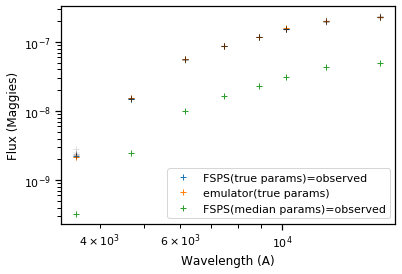

In [125]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='FSPS(true params)=observed')
plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='emulator(true params)')



plt.loglog(wavelengths, fsps(median_params.squeeze()), linestyle='', marker='+', label='FSPS(median params)=observed')

for n in range(15):
    plt.loglog(wavelengths, get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./16.)
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (Maggies)')

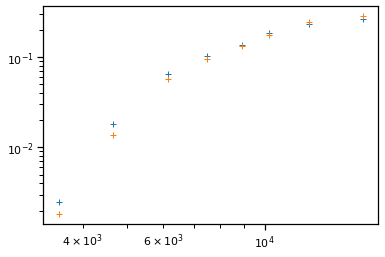

In [126]:
expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
plt.loglog(wavelengths, expected_p/expected_p.sum(), linestyle='', marker='+', label='emulator(true params)')
plt.loglog(wavelengths, fsps_p/fsps_p.sum(), linestyle='', marker='+', label='FSPS(median params)=observed')

Text(0, 0.5, 'Flux (Maggies)')

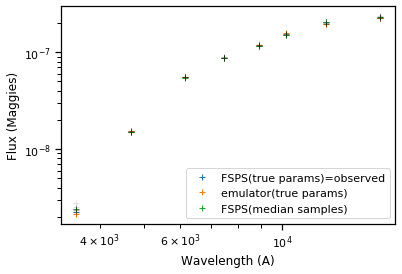

In [141]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='FSPS(true params)=observed')

expected_p = get_expected_photometry(true_params.reshape(1, -1))[0]
fsps_p = fsps(median_params.squeeze())
# plt.loglog(wavelengths, expected_p, linestyle='', marker='+', label='emulator(true params)')
fsps_norm = deep_emulator.normalise_photometry(np.expand_dims(fsps_p, axis=0))
fsps_flux = np.squeeze(deep_emulator.denormalise_photometry(fsps_norm, scale=fsps_scale))
plt.loglog(wavelengths, expected_p, linestyle='', marker='+', label='emulator(true params)')
plt.loglog(wavelengths, fsps_flux, linestyle='', marker='+', label='FSPS(median samples)')

for n in range(15):
    plt.loglog(wavelengths, get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./16.)
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux (Maggies)')

In [134]:
fsps_scale

57.83848

In [133]:
deep_emulator.denormalise_photometry(-np.log10(fsps_p), scale=fsps_scale)

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [132]:
-np.log10(fsps_p)

array([9.48901072, 8.61342926, 7.99654877, 7.77803982, 7.63935325,
       7.30390655, 7.36459323, 7.51105492])

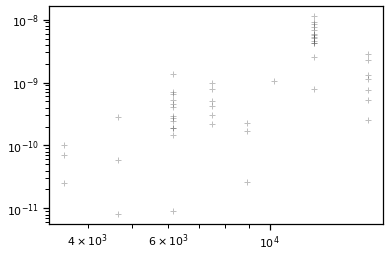

In [69]:
# plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='observed')
# plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='true params')
# plt.loglog(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0], linestyle='', marker='+', label=)
for n in range(15):
    plt.loglog(wavelengths, galaxy['true_observations'] - get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=1./4.)
# plt.legend()

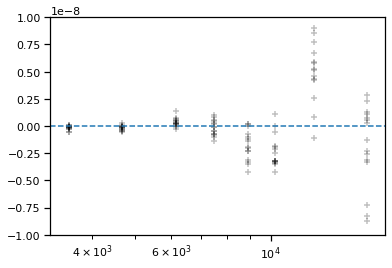

In [75]:
plt.axhline(0., linestyle='--')
for n in range(15):
    plt.scatter(wavelengths, galaxy['true_observations'] - get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], marker='+', color='k', alpha=1./4.)
    plt.ylim([-1e-8, 1e-8])
    plt.xscale('log')
# plt.legend()

In [ ]:
get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0]

In [ ]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='true', color='k')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0], linestyle='', marker='+')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 34, :].reshape(1, -1))[0], linestyle='', marker='+', color='r')

In [ ]:
by_chain_not_bad = np.concatenate([by_chain[:, :34], by_chain[:, 35:]], axis=1)
by_chain_not_bad.shape

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(1, 51, num=5).astype(int)

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain_not_bad[:, :cut, :])
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

In [ ]:
from emcee.autocorr import integrated_time

In [ ]:
# emcee is happy with time, walkers, dimensions
tau_est = integrated_time(by_chain, quiet=True)
tau_est

In [ ]:
# array([ 628.51810087,  656.14108053,  858.91637139,  925.08219734,
#        1049.84372125, 3584.59257398, 1421.13224327, 3356.72261827])

# hmc

In [ ]:
# # emcee is happy with time, walkers, dimensions
# tau_est_not_bad = integrated_time(by_chain_not_bad, quiet=True)
# tau_est_not_bad

In [ ]:
sns.barplot(y=params, x=tau_est)  # estimate tau using all chains

In [ ]:
# extinction and inclination are the most uncertain, both almost totally unknown

In [ ]:
sns.barplot(y=params, x=len(by_chain)/tau_est)  # effective samples per chain

In [ ]:
# hmc, no thinning, 1 chain (probably not a good estimate?):

# array([4594.71930395, 4106.71578812, 3291.08818621, 4068.70526458,
#        2642.20579738, 6012.44976159, 5008.85703236, 5370.88693979])

In [ ]:
# 100k samples, 30k burnin, no thinning, 256 walkers, emcee:
    
# array([4747.67220695, 4897.18058522, 5929.65856414, 5970.30192595,
#        4055.12796419, 2566.78810495, 3377.97829428, 2423.96171419])

# (too short for reliable estimate)

In [ ]:
tau_est * 10  # in real samples, prop.compute time

In [ ]:
# 100k samples, 30k burnin, 10x thinning, 256 walkers, emcee:
    
# array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453])



In [ ]:
# 100k samples HMC, 10k burnin, 10x thinning, 64 walkers, hmc:
    
# array([ 6285.1810087 ,  6561.41080526,  8589.1637139 ,  9250.82197341,
#        10498.43721253, 35845.92573981, 14211.32243268, 33567.22618269])

In [ ]:
geweke = az.geweke(np.swapaxes(galaxy['samples'], 0, 1))
geweke.shape
# plt.plot(geweke[:, 1])

In [ ]:
geweke

In [ ]:
plt.plot(geweke[:, 0])

In [ ]:
rhat = az.rhat(ds)
rhat_values = rhat.x.values
print('Not valid for emcee! walkers are correlated')
print('Values greater than one indicate that one or more chains have not yet converged.')
for n, p in enumerate(params):
    print(p, '{:.2f}'.format(rhat_values[n]))

In [ ]:
# may not be valid for walkers?

In [ ]:
_ = az.plot_autocorr(ds, max_lag=4000, combined=True)  # in thinned units

In [ ]:
_ = az.plot_autocorr(ds.x[0:1].values, max_lag=5000)  # in thinned units

In [ ]:
_ = az.plot_autocorr(ds.x[2:3].values, max_lag=5000)  # in thinned units

In [ ]:
# ds.x[30, 100, 7]  # ds.x format is (chain, sample, param)

In [ ]:
_ = az.plot_mcse(ds)

In [ ]:
ds_hmc

In [ ]:
ess = az.ess(ds_hmc)

In [ ]:
ess.x.values

In [ ]:
sns.barplot(y=params, x=ess.x.values)

In [ ]:
# Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space.
_ = az.plot_ess(ds, kind="local")

In [ ]:
_ = az.plot_ess(ds, kind="quantile")

In [ ]:
# Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
_ = az.plot_ess(ds, kind="evolution")

In [ ]:
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/backends/backend.py#L130
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/autocorr.py#L47